## 영상 프레임 추출

In [1]:
# 필요한 패키지를 불러옵니다.
import os
import cv2
import time

In [7]:
# 영상이 저장된 폴더 확인
target_folder = "./data/"
file_list = os.listdir(target_folder + 'video')

In [8]:
file_list

['경제_가격경쟁.mp4', '경제_가격수준.mp4']

In [4]:
def imwrite(filename, img, params=None): # 한글 경로 문제 해결
    try:
        ext = os.path.splitext(filename)[1]
        result, n = cv2.imencode(ext, img, params)

        if result:
            with open(filename, mode='w+b') as f:
                n.tofile(f)
            return True
        else:
            return False
    except Exception as e:
        print(e)
        return False

In [9]:
for i in range(len(file_list)):
    # 동영상 파일명과 같은 폴더 생성
    new_folder = file_list[i][:-4]  # file_list에 있는 파일 이름은 확장자를 포함
    new_path = target_folder + "img/{0}".format(new_folder)
    if not (os.path.isdir(new_path)):
        # 해당 파일명과 동일한 폴더가 없으면 생성
        os.mkdir(os.path.join(new_path))

    # 동영상 읽어서 원하는 부분 캡쳐(0.3초 간격 / 9 Frame)
    file_path = target_folder +'video/'+ file_list[i]
    cap = cv2.VideoCapture(file_path)
    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            count += 1
            if count % 9 == 0:
                save_path = new_path + "/{0:02d}.png".format(count//9)
                imwrite(save_path, frame)
            k = cv2.waitKey(33)
            if k == 27:
                break
        else:
            break

    cap.release()
    if (i % 10) == 9 :
        time.sleep(5)

## 추출된 이미지 EDA

In [21]:
# 필요한 패키지를 불러옵니다.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
target_folder = "./data/"
folder_list = os.listdir(target_folder + 'img')
folder_list

['경제_가격경쟁', '경제_가격수준']

In [14]:
df_EDA = pd.DataFrame(
    columns=["file_name", "seq_len", "img_row", "img_col",
             "R_min", "R_median", "R_max",
             "G_min", "G_median", "G_max",
             "B_min", "B_median", "B_max",
             "R_mean", "R_std",
             "G_mean","G_std",
             "B_mean", "B_std"])

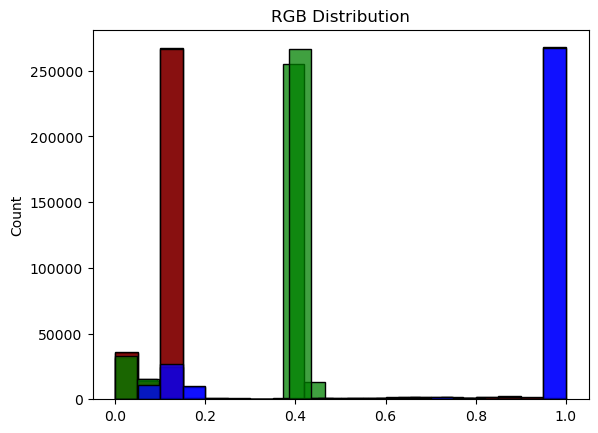

In [70]:
for i in range(len(folder_list)):
    new_row = [folder_list[i]]
    img_path = target_folder + "img/{0}".format(folder_list[i])
    img_list = os.listdir(img_path)
    new_row.append(len(img_list))
    test_img = np.asarray(plt.imread(img_path + "/{0}".format(img_list[0])))
    new_row += [test_img.shape[0], test_img.shape[1]]
    r_seq = test_img[:, :, 0].flatten()
    g_seq = test_img[:, :, 1].flatten()
    b_seq = test_img[:, :, 2].flatten()
    if i != len(folder_list):
#         plt.figure(figsize=(15, 15))
        sns.histplot(r_seq, color='maroon')
        sns.histplot(g_seq, color='green')
        sns.histplot(b_seq, color='blue').set_title("RGB Distribution")
#         plt.savefig(target_folder + "{0}_RGBdistplot.png".format(folder_list[i]), dpi = 400)
#         plt.close()
    color = [np.min(r_seq), np.median(r_seq), np.max(r_seq),
             np.min(g_seq), np.median(g_seq), np.max(g_seq),
             np.min(b_seq), np.median(b_seq), np.max(b_seq),
             np.mean(r_seq), np.std(r_seq), np.mean(g_seq),
             np.std(g_seq), np.mean(b_seq), np.std(b_seq)]
    # 얻은 정보를 데이터프레임에 추가
    df_EDA.loc[i] = new_row + color

In [23]:
df_EDA
# seq_len이 다름 -> 통일

,file_name,seq_len,img_row,img_col,R_min,R_median,R_max,G_min,G_median,G_max,B_min,B_median,B_max,R_mean,R_std,G_mean,G_std,B_mean,B_std
0,경제_가격경쟁,14,466,700,0.0,0.109804,1.0,0.0,0.419608,0.933333,0.0,1.0,1.0,0.12020,0.124542,0.369548,0.143627,0.859229,0.312808
1,경제_가격수준,17,466,700,0.0,0.109804,1.0,0.0,0.419608,0.964706,0.0,1.0,1.0,0.11842,0.123155,0.368289,0.145745,0.856800,0.316278


## 이미지 전처리

In [20]:
# 필요한 패키지를 불러옵니다.
import os
import numpy as np
import pandas as pd

In [21]:
def zero_padding_4d(img_seq, max_len):
    """
    이미지 시퀸스들 앞에 0으로 된 이미지들 padding
    텐서플로 모델에 넣기 위해서는 이미지 시퀸스의 길이를 모두 맞춰야 하므로
    :param max_len: 이미지 시퀸스의 최종 길이
    """
    img_seq = img_seq.copy()
    # 각 이미지 한 장의 크기
    img_shape = img_seq.shape[1:]
    # zero-padding으로 만들어야하는 이미지 개수
    img_augment_len = max_len - img_seq.shape[0]
    assert img_augment_len >=0, "max_len should longer than image sequence"
    if img_augment_len == 0:
        # 이미지를 늘릴 필요가 없으면 그대로 반환
        return img_seq
    # 해당하는 이미지의 크기를 가진 0 배열 생성
    img_zero = np.zeros((img_augment_len, *img_shape))
    img_seq = np.concatenate([img_zero, img_seq], axis = 0)
    return img_seq

In [22]:
def read_ai (xlen = 1280, ylen = 720):
    """
    :param xlen, ylen: 이미지를 원하는 크기로 읽어들이는 것
    :returns input, output data(리스트 타입) / max_len 이미지 시퀸스의 길이
    """
    # 각 이미지 시퀸스는 폴더에 저장되어 있음. 각 폴더가 하나의 데이터
    target_folder = "video/"
    folder_list = os.listdir(target_folder)

    dataset_annotation = pd.read_excel("수어_데이터셋_어노테이션.xlsx")
    dataset_annotation.loc[(dataset_annotation["한국어"].map(type) == int), "타입(단어/문장)"] = "숫자"
    dataset_annotation["folder_name"] = dataset_annotation["파일명"].str[:-4]

    input_data = []
    output_data = []
    # 추후에 zero-padding을 위해 이미지 시퀸스의 가장 긴 길이를 체크 해야함
    img_max_len = 0
    # for i in range(500):
    for i in range(len(folder_list)):
        img_path = target_folder + "//{0}".format(folder_list[i])
        # 각 폴더에는 해당하는 이미지들이 저장되어 있기 때문에, 폴더에 접근해서 이미지들을 순차적으로 읽어들임
        img_list = os.listdir(img_path)
        img_list.sort()
        # 메모리 문제 때문에 해당 수어가 문장 또는 숫자인 경우 제외
        if dataset_annotation[dataset_annotation["folder_name"] == folder_list[i]].iloc[0]["타입(단어/문장)"] == "문장":
            continue
        elif dataset_annotation[dataset_annotation["folder_name"] == folder_list[i]].iloc[0]["타입(단어/문장)"] == "숫자":
            continue

        if len(img_list) > img_max_len:
            # 이미지 시퀸스의 최대 길이를 갱신
            img_max_len = len(img_list)
        # 폴더 안에 있는 이미지들을 읽어서 리스트에 저장
        img_seq = []
        for j in range(len(img_list)):
            image = Image.open(img_path + "//{0}".format(img_list[j]))
            image = np.asarray(image, dtype=np.float32)
            # 이미지를 함수 호출자가 원하는 크기로 변경
            image = cv2.resize(image, dsize=(xlen, ylen))
            # 이미지 시퀸스를 만들기 위해 3차원 배열을 4차원 배열로 변환
            image = image.reshape(-1, *image.shape)
            img_seq.append(image)
        # img_seq 안에 있는 이미지를 모두 concatenate해서 하나의 4차원 배열로 만듦
        img_seq = np.concatenate(img_seq)
        input_data.append(img_seq)
        # print("Read {0} Complete".format(i))
        label = dataset_annotation[dataset_annotation["folder_name"] == folder_list[i]].loc[:, "한국어"].values[0]
        if type(label) == int:
            label = str(label)
        # 이미지 시퀸스에 해당하는 한국어 추가
        output_data.append(label)

    for i in range(len(input_data)):
        # input_data를 zero-padding해서 모두 같은 길이로 만들어준다.
        input_data[i] = zero_padding_4d(input_data[i], img_max_len)

    return input_data, output_data, img_max_len

In [ ]:
def train_test_split(data_X, data_y, category, num=5):
    """
    # 한국어를 균일하게 분배하기 위한 train_test_split 함수
    :param data_X, data_y:
    :param category: 총 카테고리 숫자
    :param num: test set으로 분리할 양
    :return:
    """
    test_idx = []
    for i in range(category):
        # 각 한국어에 해당하는 수어 영상 인덱스 추출
        cat_idx = np.where(data_y == i)[0]
        # 전체 인덱스에서 원하는 만큼의 인덱스 추출
        cat_test = np.random.choice(cat_idx, size=num, replace=False)
        test_idx.append(cat_test)
    test_idx = np.concatenate(test_idx)
    # 선택된 인덱스는 테스트 데이터로 / 나머지는 훈련 데이터로 사용
    data_y_test = data_y[test_idx]; print(np.unique(data_y_test).shape[0])
    data_y_train = np.delete(data_y, test_idx); print(np.unique(data_y_train).shape[0])
    data_X_test = data_X[test_idx, ...]; print(data_X_test.shape)
    data_X_train = np.delete(data_X, test_idx, axis=0); print(data_X_train.shape)
    return data_X_train, data_y_train, data_X_test, data_y_test

## 모델링